# Домашнее задание 3. Детекция объектов

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом, и точно не будет работать из коробки на Windows.

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [1]:
# Harry Potter -- uncomment
#!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

# Cards -- uncomment
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip



!unzip -q data.zip

--2023-12-10 19:28:36--  https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip [following]
--2023-12-10 19:28:36--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38392108 (37M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  36.61M   239MB/s    in 0.2s    

2023-12-10 19:28:36 (239 MB/s) - ‘data.zip’ saved [38392108/38392108]



# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [2]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

Функции можно и нужно передать некий class_dict. Он есть и при инициализации датасета ниже. С его помощью можно название класса превратить в int. Далее подразумевается, что класс идёт как int.

In [3]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
        # you need: xmin ymin xmax ymax, class in dict
        xmin = int(member.find('bndbox/xmin').text)
        ymin = int(member.find('bndbox/ymin').text)
        xmax = int(member.find('bndbox/xmax').text)
        ymax = int(member.find('bndbox/ymax').text)
        class_label = class_dict[str(member.find("name").text)]
        res = [xmin, ymin, xmax, ymax, class_label]


        bboxes.append(res)

    return bboxes

In [4]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        ### YOUR CODE HERE ###

        fname = self.filenames[idx]
        image = np.array(Image.open(fname).convert('RGB'))
        bboxes = get_xml_data(fname, self.root, self.class_dict)

        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        ### YOUR CODE HERE ###

        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [5]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [6]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.

В датасете есть class_dict_inv, который позволит вам сделать обратное преобразование: int, содержащий класс, в строку с названием.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [7]:
def visualize(images, bboxes):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break
        # Вот тут нужно выполнить permute (вспомните где у torch каналы, а где они у matplotlib)
        # И откатить нормализацию (просто обратное преобразование)
        # Имена и количества классов можно подтянуть из датасета через train_ds.class_dict_inv

        image = images[i].permute(1, 2, 0)
        image = image * np.array(std) + np.array(mean)

        ax.imshow(image)

        for bbox in bboxes[i]:
          xmin, ymin, xmax, ymax, class_label = bbox
          class_id = train_ds.class_dict_inv[class_label]
          rect = plt.Rectangle(
              (xmin, ymin), xmax - xmin, ymax - ymin, linewidth = 1, edgecolor = 'r', facecolor = 'none'
          )
          ax.add_patch(rect)
          ax.text(xmin, ymin,class_id, fontsize=9, color='r')

    fig.tight_layout()
    plt.show()

У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://gcdnb.pbrd.co/images/n8BnhhfCgYnQ.png)

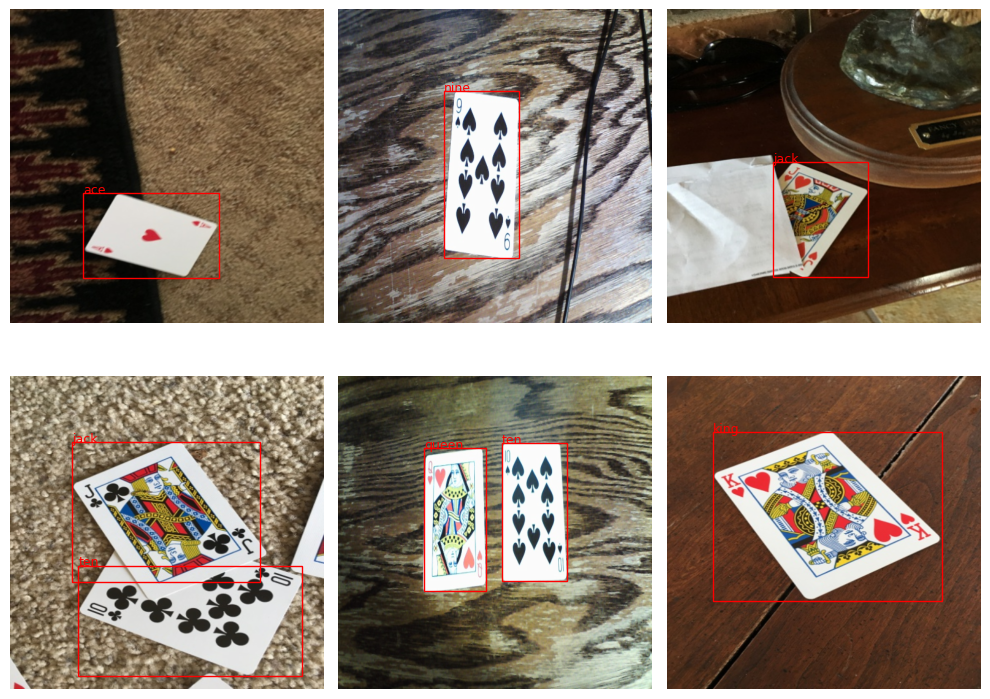

In [8]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# Задача 3. 3 балла.
## YOLO-like детектор

Сейчас нам предстоить реализовать детектор, похожий на YOLO. Это один из самых простых детекторов с точки зрения реализации. YOLO описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Здесь мы его немного изменим и упростим. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

We convert lists of bounding boxes to the target downsampled grid. For this we

* compute centers of bounding boxes ($c_x, c_y$)
* change center coordinates (offset from the top left corner for each corresponding grid cell on a small grid)
* normalize box height and with to $[0, 1]$
* fill the target grid with values

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и сгенерировать тензор размера Bx16x16x6. Первая размерность - это количество примеров в батче. Далее идут две пространственные размерности, это сетка 16 на 16.

В каналах у нас будут записаны:
* Сдвиги центра bbox относительно начала клеточки (клеточка это "пиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)
* Нормализованные ширина и высота bbox. 2 канала (W, H)
* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал
* Класс детекции (тот самый int, полученный из строки с названием)

In [9]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
        x_cell =  downsample # TODO размер клетки по X в пикс
        y_cell = downsample # TODO размер клетки по Y в пикс
        w_box = (xmax - xmin) / w # TODO ширина бокса отнормированная
        h_box = (ymax - ymin) / h # TODO высота бокса отнормированная

        # Посчитайте координаты центра и сдвиги
        cx =  (xmax + xmin) / 2# TODO (координаты центра в исходных координатах)
        cy = (ymax + ymin) / 2 # TODO
        cx_idx = (cx // downsample).to(torch.long)
         # TODO (посчитайте индекс центра на карте признаков размера 16x16. Это будут как раз координаты пикселя, куда мы запишем параметры коробки)
        cy_idx = (cy // downsample).to(torch.long) # TODO

        cx_box = (cx - cx_idx * downsample) / downsample # TODO (посчитайте сдивиги относительно cx_idx)
        cy_box = (cy - cy_idx * downsample) / downsample # TODO

        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

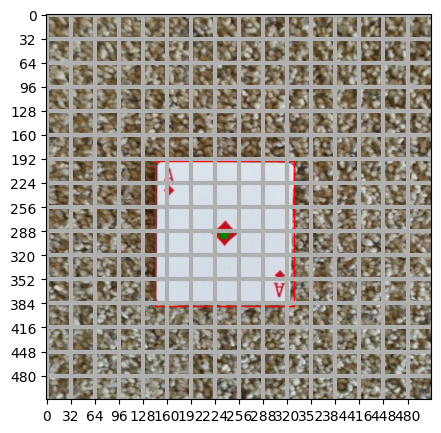

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Задача 3.2. 0.5 балла.

Выход нашей сетки будет несколько больше, чем Bx16x16x6. Почему?

Мы решаем задачу, где классов больше одного. Вспомним прошлое дз: target был одним числом, но выход сетки содержал длинный-длинный вектор, из которого мы получали вероятность принадлежности к тому или иному классу. Здесь то же самое, но как бы в двумерии: у каждой клеточки из этих 16*16 будет свой вектор длины C, который мы будем использовать для определения класса.

Реализуйте обратное относительно collate_fn преобразования, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже должны получить набор прямоугольников и тоже с корректными классами.

То есть, нужно проделать операции из collate_fn в обратную сторону, но учесть, что у неройнки выход будет чуть длиннее, и там мы должны брать argmax для определения класса.

Hint: в target classes идут в конце. В нейронке они тоже будут в конце, но их будет больше 1. Можно проверять число каналов пришедшего объекта, если оно 6, то перед нами target и надо брать значение, которое записано в клеточке. Иначе (каналов больше 6) перед нами выход нейронки, и надо брать самый вероятный из них.

In [11]:
def decode_prediction(pred, upsample=32, threshold=0.7):
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample
    ### YOUR CODE HERE ###
    decoded_boxes = list()
    boxes = list()
    for batch in range(b):
      for cy_idy in range(h):
        for cx_idx in range(w):
          confidence = pred[batch, :, cy_idy, cx_idx][4]
          #cx_box, cy_box, w_box, h_box, confidence, classes = pred[batch, :, cx_idx, cy_idy]
          if confidence >= threshold:
            cx_box, cy_box, w_box, h_box = pred[batch, :, cy_idy, cx_idx][:4]
            w_1 = w_box * img_w
            h_1 = h_box * img_h
            cx = (cx_idx + cx_box) * upsample
            cy = (cy_idy + cy_box) * upsample
            xmax = (2 * cx + w_box * img_w) / 2
            xmin = (2 * cx - w_box * img_w) / 2
            ymax = (2 * cy + h_box * img_h) / 2
            ymin = (2 * cy - h_box * img_h) / 2

            if c == 6:
              classes = pred[batch, :, cy_idy, cx_idx][5]
            else:
              classes = torch.argmax(pred[batch, :, cy_idy, cx_idx][5:]).tolist()

            decoded_boxes.append([xmin, ymin, xmax, ymax, classes])
      boxes.append(decoded_boxes)
      decoded_boxes = list()

    return boxes

## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 включительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [13]:
C = 6
# Количество классов в вашем датасете, хоть руками посчитайте, хоть подтяните из словаря классов


class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.model = nn.Sequential(*(list(model.children())[:-2]))
        self.relu = nn.ReLU()
        self.conv = nn.Sequential(nn.Conv2d(2048, 512, kernel_size=3, padding=1),
                                 nn.BatchNorm2d(512),
                                 self.relu,
                                  nn.Conv2d(512, 128, kernel_size=3, padding=1),
                                 nn.BatchNorm2d(128),
                                 self.relu,
                                  nn.Conv2d(128, 32, kernel_size=3, padding=1),
                                 nn.BatchNorm2d(32),
                                 self.relu,
                                  nn.Conv2d(32, 11, kernel_size=3, padding=1),
                                 nn.BatchNorm2d(11),
                                 nn.Sigmoid())

    def forward(self, img):
        with torch.no_grad():
          out_first = self.model(img)
        out = self.conv(out_first)
        return out

## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)


* Ниже есть assert. Если вы экспериментируете с лоссом, он не будет проходить, не обращайте на него внимание. Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. assert написан для 3 классов, в задаче с картами их 6. Подумайте как зависит индексация от параметра C и используйте его.

In [20]:
def special_loss(pred, target, check=False, C=C):
    ### YOUR CODE HERE ###
    mask = target[:, 4, :, :].ge(0.01)
    localization_loss = nn.MSELoss(reduction='sum')(torch.masked_select(pred[:, 0, :, :],mask),
                                                    torch.masked_select(target[:, 0, :, :],mask)) + \
                                                     nn.MSELoss(reduction='sum')(torch.masked_select(pred[:, 1, :, :],mask),
                                                                                torch.masked_select(target[:, 1, :, :],mask))
    box_loss = nn.MSELoss(reduction='sum')(torch.masked_select(torch.sqrt(pred[:, 2, :, :]), mask=mask),
              torch.masked_select(torch.sqrt(target[:, 2, :, :]), mask=mask)) + \
               nn.MSELoss(reduction='sum')(torch.masked_select(torch.sqrt(pred[:, 3, :, :]), mask=mask),
                  torch.masked_select(torch.sqrt(target[:, 3, :, :]), mask=mask))
    classes = list()
    for i in range(C):
      classes.append(torch.masked_select(pred[:, 5 + i, :, :], mask))
    classes = torch.stack(classes, dim = 1)
    classification_loss = nn.CrossEntropyLoss(reduction='sum')(
        classes, torch.masked_select(target[:, 5, :, :].long(), mask)
    )
    confidence_loss = nn.BCELoss(reduction='sum')(torch.masked_select(pred[:, 4, :, :], mask), torch.masked_select(target[:, 4, :, :], mask)) + \
                      0.01 * nn.BCELoss(reduction='sum')(torch.masked_select(pred[:, 4, :, :], ~mask), torch.masked_select(target[:, 4, :, :], ~mask))

    if not check:
        return 10 * localization_loss + box_loss + classification_loss + 5 * confidence_loss

    else:
        return localization_loss, box_loss, classification_loss, confidence_loss

# Задача 4. 2 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [21]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS =  15
# Harry Potter 20, Cards 15
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
        batch['image'] = batch['image'].to(device)
        opt.zero_grad()
        output = model(batch['image'].to(device))
        loss = special_loss(output, batch['target'].to(device))
        loss.backward()
        opt.step()
        epoch_losses.append(loss.item())
        pbar.set_postfix({'Loss': np.mean(epoch_losses)})

    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 0 done; Train loss 165.851;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1 done; Train loss 128.142;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2 done; Train loss 116.835;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3 done; Train loss 113.553;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4 done; Train loss 108.939;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5 done; Train loss 107.377;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6 done; Train loss 104.556;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7 done; Train loss 97.723;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8 done; Train loss 91.976;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9 done; Train loss 88.192;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10 done; Train loss 86.098;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 11 done; Train loss 85.446;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 12 done; Train loss 83.267;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 13 done; Train loss 81.802;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 14 done; Train loss 80.707;


Запустим обученный детектор на тестовых изображениях:

In [23]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [24]:
# Нужно сделать предсказание и переложить результат на cpu
model.eval()
img, target = batch['image'], batch['target']
with torch.no_grad():
    res = model(img.to(device)).cpu()
### YOUR CODE HERE ###

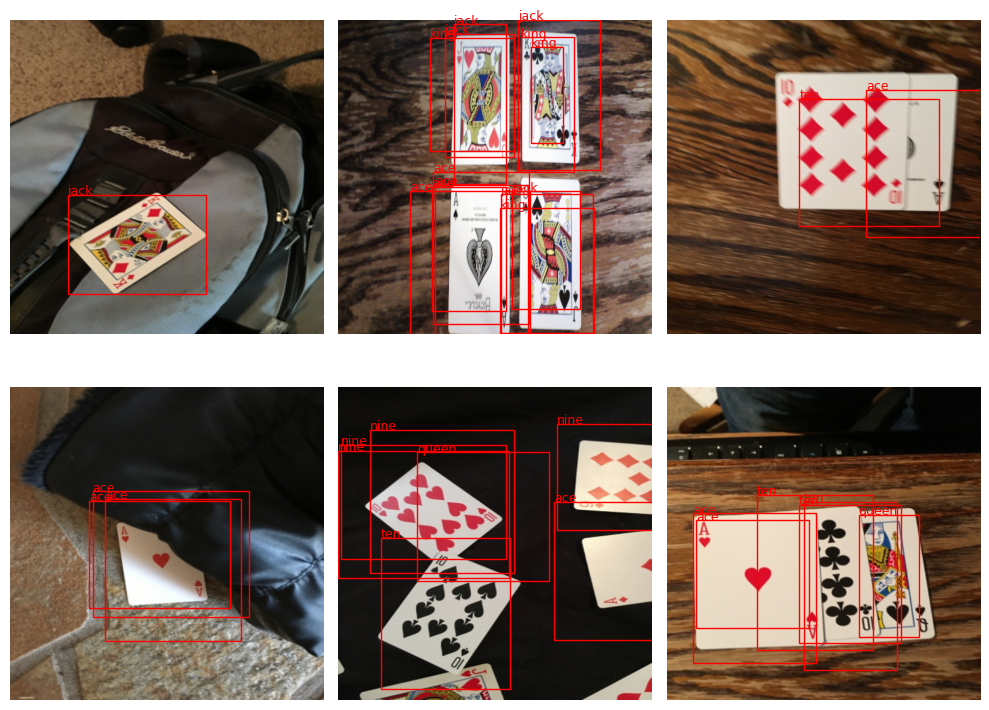

In [25]:
# Сделайте визуализацию. Поиграйтесь с threshold, скорее всего нужно понизить до ~0.1
bboxes = decode_prediction(res, upsample = 32, threshold = 0.7)
img = img.cpu()
visualize([image for image in img], [bbox for bbox in bboxes])
### YOUR CODE HERE ###

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO v8 от ultralytics.

In [26]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.4/660.4 kB 6.2 MB/s eta 0:00:00


## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [27]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO v8. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

In [29]:
def annotation2txt(bboxes, w_im, h_im):
    ### YOUR CODE HERE ###
    string = list()
    for bbox in bboxes:
      xmin, ymin, xmax, ymax, classes = bbox
      w_box = (xmax - xmin) / w_im
      h_box = (ymax - ymin) / h_im
      cx = (xmax + xmin) / (2 * w_im)
      cy = (ymax + ymin) / (2 * h_im)
      st = str(classes) + ' ' + str(cx) + ' ' + str(cy) + ' ' + str(w_box) + ' ' + str(h_box)

      string.append(st)

    return string

In [30]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )

    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [31]:
# Собираем YAML

nc = len(train_ds.class_dict) # Укажите число классов. Хоть руками, хоть по-умному посчитайте (см. class_dict)
names = list(train_ds.class_dict.keys()) # Укажите имена классов. Хоть руками, хоть по-умному посчитайте, это массив строк (см. class_dict)

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Задание 5.2. 1.5 балла.

Обучите модель YOLO v8 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель нужно взять необученную!

Подсказка: подумайте зачем вам data.yaml и что такое yolov8n.yaml (не стесняйтесь гуглить)

In [32]:
import ultralytics
from ultralytics import YOLO

model = YOLO('yolov8n.yaml')
res = model.train(data='data.yaml', epochs=100, imgsz=512)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 755k/755k [00:00<00:00, 21.3MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 119MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels... 326 images, 0 backgrounds, 0 corrupt: 100%|██████████| 326/326 [00:00<00:00, 2006.64it/s]

train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels... 37 images, 0 backgrounds, 7 corrupt: 100%|██████████| 37/37 [00:00<00:00, 1427.54it/s]

val: WARNING ⚠️ /content/valid/images/cam_image12.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2196]
val: WARNING ⚠️ /content/valid/images/cam_image16.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0952]
val: WARNING ⚠️ /content/valid/images/cam_image21.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1574]
val: WARNING ⚠️ /content/valid/images/cam_image23.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0622]
val: WARNING ⚠️ /content/valid/images/cam_image37.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.5013      1.5093]
val: WARNING ⚠️ /content/valid/images/cam_image38.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.7209      1.1534       1.713      1.1389]
val: WARNING ⚠️ /content/valid/images/cam_image6.jpg: ignoring corrupt image/label: non-normal

Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.73G      3.186      4.594       4.38         21        512: 100%|██████████| 21/21 [00:09<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

                   all         30         52   0.000702     0.0915   0.000536   8.42e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.98G      3.136      4.231      4.119         18        512: 100%|██████████| 21/21 [00:06<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         30         52    0.00041     0.0545   0.000306    6.7e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         2G      3.048      3.851      3.856         31        512: 100%|██████████| 21/21 [00:07<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         30         52   0.000317      0.036   0.000287   6.42e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         2G      2.925      3.531      3.569         27        512: 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all         30         52   0.000629      0.073   0.000626   0.000112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.98G      2.765      3.381      3.388         28        512: 100%|██████████| 21/21 [00:08<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         30         52      0.544      0.037     0.0376     0.0178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         2G      2.704      3.316      3.243         17        512: 100%|██████████| 21/21 [00:07<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         30         52     0.0839      0.133      0.106     0.0503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.99G      2.569      3.053      3.076         24        512: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all         30         52      0.209      0.266      0.175     0.0976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         2G      2.391      2.967      2.928         24        512: 100%|██████████| 21/21 [00:07<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         30         52      0.264      0.228      0.232      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.98G      2.232       2.82      2.787         29        512: 100%|██████████| 21/21 [00:09<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         30         52      0.301      0.548      0.297      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.99G      2.137      2.739      2.724         24        512: 100%|██████████| 21/21 [00:04<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         30         52      0.531       0.22      0.222      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.98G      1.969      2.547       2.53         20        512: 100%|██████████| 21/21 [00:06<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         30         52      0.345      0.485      0.371      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.99G       1.84      2.532      2.452         18        512: 100%|██████████| 21/21 [00:06<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         30         52      0.269      0.464      0.382      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.98G       1.79      2.387      2.348         22        512: 100%|██████████| 21/21 [00:06<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         30         52      0.398      0.542       0.41      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.02G      1.771      2.346      2.321         15        512: 100%|██████████| 21/21 [00:04<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]

                   all         30         52      0.277      0.454       0.31      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.99G      1.624      2.201      2.195         23        512: 100%|██████████| 21/21 [00:04<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         30         52      0.399      0.606      0.477      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.99G      1.582      2.199      2.143         20        512: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         30         52      0.391       0.64      0.469      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.98G      1.559      2.129      2.123         15        512: 100%|██████████| 21/21 [00:04<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         30         52      0.303       0.62      0.427       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.99G       1.46      2.052      2.055         26        512: 100%|██████████| 21/21 [00:06<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all         30         52      0.447      0.695      0.511      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         2G      1.432      2.105      2.021         15        512: 100%|██████████| 21/21 [00:04<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

                   all         30         52      0.393      0.695      0.481      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         2G      1.388      1.926      1.954         18        512: 100%|██████████| 21/21 [00:05<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         30         52      0.413      0.723      0.535      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.99G      1.381      1.901      1.936         22        512: 100%|██████████| 21/21 [00:05<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         30         52      0.396      0.601      0.475      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.99G        1.3      1.852      1.857         11        512: 100%|██████████| 21/21 [00:04<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         30         52       0.44      0.722      0.542      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.99G      1.293      1.833       1.85         29        512: 100%|██████████| 21/21 [00:06<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

                   all         30         52      0.455      0.698      0.557      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.99G      1.334      1.877      1.898         16        512: 100%|██████████| 21/21 [00:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         30         52      0.483       0.77      0.569      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.98G      1.276      1.817      1.818         23        512: 100%|██████████| 21/21 [00:06<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

                   all         30         52      0.411       0.76      0.574      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.99G      1.296      1.784      1.859         33        512: 100%|██████████| 21/21 [00:04<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all         30         52      0.442      0.724      0.571      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.99G       1.27      1.798      1.809         23        512: 100%|██████████| 21/21 [00:04<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         30         52      0.413      0.715      0.586      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         2G      1.179      1.693      1.724         22        512: 100%|██████████| 21/21 [00:05<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         30         52      0.448      0.852      0.603       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.98G       1.19      1.761      1.737         14        512: 100%|██████████| 21/21 [00:04<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all         30         52       0.47       0.79      0.558      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.99G      1.217      1.694      1.749         20        512: 100%|██████████| 21/21 [00:06<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         30         52      0.424      0.762       0.61      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.99G      1.152      1.634      1.695         26        512: 100%|██████████| 21/21 [00:04<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all         30         52      0.478      0.871       0.64      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.99G       1.15      1.651      1.696         22        512: 100%|██████████| 21/21 [00:05<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all         30         52      0.464      0.808      0.648      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.97G      1.124      1.621      1.667         28        512: 100%|██████████| 21/21 [00:04<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all         30         52      0.487      0.711      0.559      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         2G      1.115      1.603      1.631         30        512: 100%|██████████| 21/21 [00:04<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         30         52      0.459      0.724      0.603      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.99G      1.056      1.546      1.577         21        512: 100%|██████████| 21/21 [00:06<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all         30         52      0.491      0.746       0.62      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.99G      1.016      1.528      1.587         25        512: 100%|██████████| 21/21 [00:04<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         30         52      0.501      0.882      0.669      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.97G      1.021      1.514      1.565         16        512: 100%|██████████| 21/21 [00:05<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         30         52      0.479      0.917      0.708       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         2G      1.002      1.492      1.544         27        512: 100%|██████████| 21/21 [00:04<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all         30         52      0.504      0.771      0.631      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         2G     0.9828      1.471      1.522         33        512: 100%|██████████| 21/21 [00:04<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all         30         52        0.6       0.79      0.689      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.99G       1.03      1.497      1.553         19        512: 100%|██████████| 21/21 [00:07<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         30         52       0.52       0.79      0.692      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.98G     0.9824      1.453      1.529         22        512: 100%|██████████| 21/21 [00:04<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all         30         52      0.651       0.83      0.757      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.99G     0.9992      1.436      1.529         15        512: 100%|██████████| 21/21 [00:05<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         30         52      0.663      0.744      0.722      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.99G     0.9498      1.418      1.494         16        512: 100%|██████████| 21/21 [00:04<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         30         52      0.745      0.714      0.788      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         2G     0.9346      1.382      1.472         19        512: 100%|██████████| 21/21 [00:06<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

                   all         30         52      0.469      0.874       0.73      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.98G     0.9411      1.413      1.496         27        512: 100%|██████████| 21/21 [00:04<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

                   all         30         52      0.586      0.702       0.67      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         2G     0.9576       1.43      1.514         12        512: 100%|██████████| 21/21 [00:04<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all         30         52      0.555      0.824      0.718      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.99G     0.9213      1.397      1.449         23        512: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all         30         52       0.56      0.779      0.726      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      1.99G     0.9551      1.412      1.476         26        512: 100%|██████████| 21/21 [00:04<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all         30         52      0.643      0.743      0.738       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      1.97G      0.892      1.346      1.444         27        512: 100%|██████████| 21/21 [00:06<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all         30         52      0.546      0.874      0.766      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         2G     0.8963      1.328      1.445         21        512: 100%|██████████| 21/21 [00:04<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all         30         52       0.54      0.921      0.744      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      1.99G     0.9103      1.316      1.437         28        512: 100%|██████████| 21/21 [00:04<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         30         52      0.651      0.832      0.802      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.98G     0.9272      1.329       1.46         27        512: 100%|██████████| 21/21 [00:05<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         30         52      0.667      0.846      0.805      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      1.98G     0.8716      1.272      1.398         15        512: 100%|██████████| 21/21 [00:04<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all         30         52      0.655      0.813      0.779       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.99G     0.9191      1.314      1.454         18        512: 100%|██████████| 21/21 [00:06<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         30         52      0.687       0.86      0.789      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      1.99G     0.8648      1.254      1.423         22        512: 100%|██████████| 21/21 [00:04<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         30         52      0.684      0.777      0.825       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.99G     0.8638        1.3      1.412         19        512: 100%|██████████| 21/21 [00:04<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         30         52      0.686      0.704      0.795      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.99G     0.8349      1.229      1.385         22        512: 100%|██████████| 21/21 [00:05<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         30         52      0.665      0.875       0.82      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      1.99G     0.8782      1.223      1.417         18        512: 100%|██████████| 21/21 [00:04<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all         30         52      0.669      0.871      0.789      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.99G     0.8391      1.245      1.379         28        512: 100%|██████████| 21/21 [00:06<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         30         52      0.642      0.889      0.813      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.99G     0.8309      1.218      1.354         21        512: 100%|██████████| 21/21 [00:04<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         30         52      0.625      0.797      0.795      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.97G     0.8344      1.218      1.371         32        512: 100%|██████████| 21/21 [00:05<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         30         52      0.685      0.824       0.79      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.99G     0.8172      1.191      1.339         13        512: 100%|██████████| 21/21 [00:05<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         30         52      0.712      0.881      0.866      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.99G      0.816      1.188      1.362         25        512: 100%|██████████| 21/21 [00:04<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all         30         52      0.651      0.885       0.84      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.99G     0.8532       1.19      1.382         28        512: 100%|██████████| 21/21 [00:06<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all         30         52      0.734      0.911      0.863      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      1.98G     0.8241      1.205      1.357         20        512: 100%|██████████| 21/21 [00:04<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         30         52      0.676      0.893      0.833      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      1.99G     0.8244      1.199      1.373         27        512: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         30         52       0.85      0.761       0.85      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         2G     0.8578       1.25      1.398         12        512: 100%|██████████| 21/21 [00:05<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]

                   all         30         52      0.769      0.812      0.837      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      1.98G     0.8013      1.179      1.334         20        512: 100%|██████████| 21/21 [00:04<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

                   all         30         52       0.73      0.842      0.906       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.98G      0.792      1.165      1.332         19        512: 100%|██████████| 21/21 [00:06<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

                   all         30         52      0.631       0.88       0.86      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         2G     0.8003      1.134      1.337         14        512: 100%|██████████| 21/21 [00:04<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         30         52      0.761      0.765      0.874      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.99G     0.8032      1.148      1.332         21        512: 100%|██████████| 21/21 [00:06<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all         30         52      0.732       0.83      0.888      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.99G     0.7895      1.128      1.312         21        512: 100%|██████████| 21/21 [00:04<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all         30         52      0.821      0.816      0.901      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.98G     0.7949      1.154      1.323         16        512: 100%|██████████| 21/21 [00:04<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all         30         52      0.712      0.807      0.856      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         2G     0.7674      1.091      1.309         28        512: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         30         52       0.78      0.878      0.889      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      1.99G      0.734      1.055      1.283         16        512: 100%|██████████| 21/21 [00:04<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

                   all         30         52      0.715      0.872      0.846      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.98G     0.7489      1.077      1.286         22        512: 100%|██████████| 21/21 [00:06<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         30         52      0.727       0.77      0.805      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.98G     0.7539      1.074      1.303         21        512: 100%|██████████| 21/21 [00:04<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all         30         52      0.736       0.81      0.854      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         2G     0.7483      1.067       1.29         22        512: 100%|██████████| 21/21 [00:04<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all         30         52      0.757      0.838      0.878       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      1.99G     0.7291      1.044      1.297         22        512: 100%|██████████| 21/21 [00:05<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all         30         52      0.691      0.811      0.838      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.98G     0.7573      1.054       1.31         22        512: 100%|██████████| 21/21 [00:04<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

                   all         30         52      0.764      0.891       0.92       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      1.98G     0.7526      1.036      1.298         19        512: 100%|██████████| 21/21 [00:06<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         30         52      0.709       0.89      0.886       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         2G     0.7112      1.024      1.253         33        512: 100%|██████████| 21/21 [00:04<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all         30         52      0.829       0.83      0.915      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      1.99G     0.7526      1.027      1.282         16        512: 100%|██████████| 21/21 [00:04<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         30         52      0.869      0.828       0.92      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      1.99G     0.7249      1.037      1.278         20        512: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         30         52       0.83      0.781      0.881      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      1.98G     0.7394       1.04      1.295         28        512: 100%|██████████| 21/21 [00:04<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         30         52      0.724      0.846      0.873      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      1.99G     0.7158     0.9841      1.288         15        512: 100%|██████████| 21/21 [00:06<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all         30         52      0.933      0.783      0.922      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      1.99G     0.6919     0.9595      1.249         19        512: 100%|██████████| 21/21 [00:04<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         30         52      0.949      0.796      0.937      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      1.99G     0.7043     0.9742      1.245         26        512: 100%|██████████| 21/21 [00:04<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         30         52      0.919      0.803      0.928      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.01G     0.6715     0.9623      1.238         17        512: 100%|██████████| 21/21 [00:05<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         30         52      0.871      0.877       0.95      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      1.99G     0.6865     0.9413      1.243         19        512: 100%|██████████| 21/21 [00:04<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         30         52      0.894      0.802      0.935      0.812


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.98G     0.6084     0.8657      1.185         15        512: 100%|██████████| 21/21 [00:08<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all         30         52      0.801      0.886      0.936      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      1.98G     0.5801     0.8321       1.16         11        512: 100%|██████████| 21/21 [00:04<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all         30         52      0.948      0.782      0.934      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      1.97G     0.5526     0.7992      1.124         12        512: 100%|██████████| 21/21 [00:05<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all         30         52      0.871       0.72      0.885      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      1.98G     0.5605      0.796      1.133         11        512: 100%|██████████| 21/21 [00:04<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all         30         52      0.897      0.841      0.922      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      1.98G     0.5494     0.7638      1.119         10        512: 100%|██████████| 21/21 [00:04<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

                   all         30         52      0.802      0.879      0.928      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      1.98G      0.535     0.7603      1.133         14        512: 100%|██████████| 21/21 [00:06<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

                   all         30         52      0.862      0.818       0.92      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      1.97G     0.5381     0.7401      1.115         14        512: 100%|██████████| 21/21 [00:04<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

                   all         30         52      0.942      0.836      0.936       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      1.98G     0.5172      0.704      1.101         10        512: 100%|██████████| 21/21 [00:05<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         30         52      0.812        0.9      0.927      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.98G     0.5248      0.711      1.105          8        512: 100%|██████████| 21/21 [00:04<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         30         52      0.936      0.835      0.939      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      1.98G     0.5436     0.7043      1.121          8        512: 100%|██████████| 21/21 [00:04<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

                   all         30         52      0.952      0.809      0.934      0.813



100 epochs completed in 0.184 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.226 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


                   all         30         52      0.942      0.836      0.936      0.822
                  king         30          8        0.9      0.875      0.917      0.872
                  jack         30          6          1      0.625      0.863      0.687
                   ace         30         12      0.849      0.942      0.977      0.883
                   ten         30         11      0.975      0.909       0.96      0.836
                  nine         30          9      0.942          1      0.995        0.9
                 queen         30          6      0.984      0.667      0.903      0.755
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train


## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.

In [33]:
### YOUR CODE HERE ###
images = ['/content/valid/images/IMG_2383.JPG', '/content/valid/images/IMG_2490.JPG', '/content/valid/images/IMG_2565.JPG',
          '/content/valid/images/IMG_2611.JPG', '/content/valid/images/IMG_2677.JPG', '/content/valid/images/IMG_2690.JPG']
res = model.predict(images, save=True)


0: 512x384 1 ace, 1: 512x384 1 king, 1 jack, 2: 512x384 1 king, 2 tens, 1 nine, 1 queen, 3: 512x384 1 jack, 1 ace, 2 tens, 1 nine, 4: 512x384 1 ten, 2 nines, 5: 512x384 1 king, 1 jack, 58.1ms
Speed: 1.1ms preprocess, 9.7ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/train2


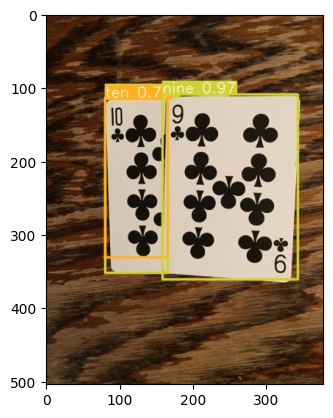

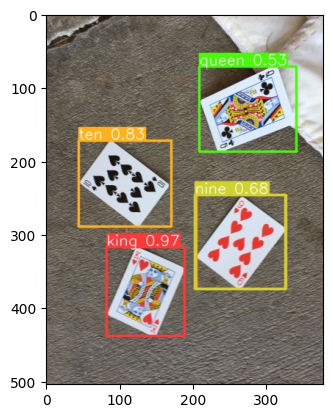

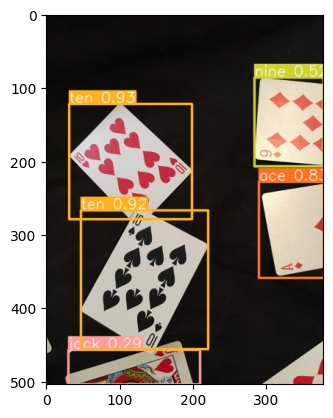

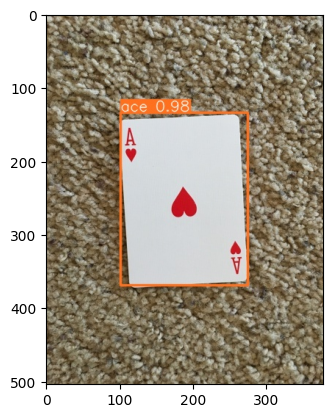

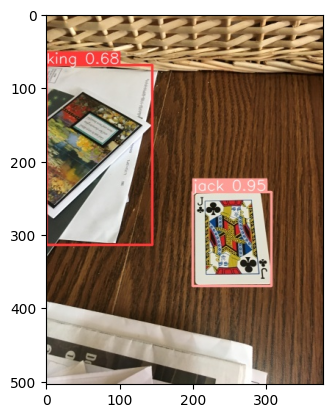

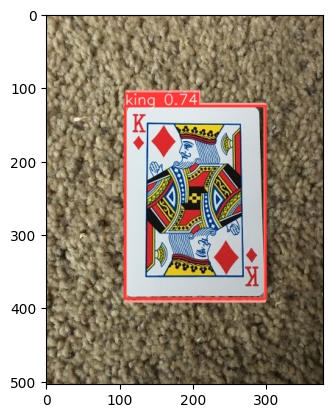

In [36]:
images = []
for f in glob.iglob("/content/runs/detect/train2/*"):
    images.append(np.asarray(Image.open(f)))
for img in images:
  imgplot = plt.imshow(img)
  plt.show()